In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# tp atr - 4, 6
# sl atr - 3, 5
# sl - Close, Low

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672564611000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [6]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low     Volume
0     2023-01-01 17:44:59  1194.76  1195.98  1195.99  1194.76   450.9908
1     2023-01-01 17:59:59  1195.98  1196.48  1196.55  1195.60   738.0895
2     2023-01-01 18:14:59  1196.47  1196.29  1196.48  1195.70   489.0501
3     2023-01-01 18:29:59  1196.29  1196.21  1196.34  1195.98   380.1043
4     2023-01-01 18:44:59  1196.22  1195.66  1196.22  1195.59   556.5141
...                   ...      ...      ...      ...      ...        ...
8309  2023-03-29 08:14:59  1773.00  1773.48  1776.00  1772.48  4097.5369
8310  2023-03-29 08:29:59  1773.47  1776.05  1778.30  1773.15  5809.1416
8311  2023-03-29 08:44:59  1776.05  1775.00  1776.70  1774.10  3034.0561
8312  2023-03-29 08:59:59  1775.00  1775.24  1776.46  1773.03  3948.1338
8313  2023-03-29 09:14:59  1775.24  1776.26  1776.42  1775.24   304.4928

[8314 rows x 6 columns]


In [7]:
df = rawdf.copy()

In [8]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr8
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff()

In [9]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low     Volume  \
0     2023-01-01 17:44:59  1194.76  1195.98  1195.99  1194.76   450.9908   
1     2023-01-01 17:59:59  1195.98  1196.48  1196.55  1195.60   738.0895   
2     2023-01-01 18:14:59  1196.47  1196.29  1196.48  1195.70   489.0501   
3     2023-01-01 18:29:59  1196.29  1196.21  1196.34  1195.98   380.1043   
4     2023-01-01 18:44:59  1196.22  1195.66  1196.22  1195.59   556.5141   
...                   ...      ...      ...      ...      ...        ...   
8309  2023-03-29 08:14:59  1773.00  1773.48  1776.00  1772.48  4097.5369   
8310  2023-03-29 08:29:59  1773.47  1776.05  1778.30  1773.15  5809.1416   
8311  2023-03-29 08:44:59  1776.05  1775.00  1776.70  1774.10  3034.0561   
8312  2023-03-29 08:59:59  1775.00  1775.24  1776.46  1773.03  3948.1338   
8313  2023-03-29 09:14:59  1775.24  1776.26  1776.42  1775.24   304.4928   

            ema_8       ema_18       ema_38       atr        rsi      slowk  \
0       

In [10]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] >= df['ema_38']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4 , 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2023-01-01 17:44:59,1194.76,1195.98,1195.99,1194.76,450.9908,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 17:59:59,1195.98,1196.48,1196.55,1195.60,738.0895,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 18:14:59,1196.47,1196.29,1196.48,1195.70,489.0501,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 18:29:59,1196.29,1196.21,1196.34,1195.98,380.1043,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 18:44:59,1196.22,1195.66,1196.22,1195.59,556.5141,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,2023-03-29 08:14:59,1773.00,1773.48,1776.00,1772.48,4097.5369,1772.785182,1770.216888,1761.633667,6.574573,59.138742,71.083591,59.906276,False,False,True,True,True,False,False
8310,2023-03-29 08:29:59,1773.47,1776.05,1778.30,1773.15,5809.1416,1773.510697,1770.830900,1762.372966,6.472818,61.672531,86.196319,70.606951,False,False,True,True,True,False,False
8311,2023-03-29 08:44:59,1776.05,1775.00,1776.70,1774.10,3034.0561,1773.841654,1771.269753,1763.020506,6.196188,60.034580,79.754601,79.011504,False,False,True,True,True,False,False
8312,2023-03-29 08:59:59,1775.00,1775.24,1776.46,1773.03,3948.1338,1774.152397,1771.687673,1763.647147,5.998603,60.294159,81.226994,82.392638,True,True,True,True,True,True,False


In [12]:
entry_df = conditions(df)

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']

sl_atr = 3
tp_atr = 6

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= take_profit):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


               Close_Time     Open    Close     High      Low     Volume  \
38    2023-01-02 03:14:59  1200.93  1203.33  1203.39  1200.92  2032.4596   
39    2023-01-02 03:29:59  1203.33  1203.62  1204.51  1202.22  2359.3542   
40    2023-01-02 03:44:59  1203.62  1202.51  1203.70  1202.50  1239.8669   
41    2023-01-02 03:59:59  1202.51  1201.78  1202.73  1201.50  1018.9498   
43    2023-01-02 04:29:59  1202.19  1202.98  1204.67  1202.19  1842.7594   
...                   ...      ...      ...      ...      ...        ...   
8293  2023-03-29 04:14:59  1785.84  1780.92  1790.54  1779.95  8923.2602   
8298  2023-03-29 05:29:59  1769.00  1773.81  1774.43  1768.58  4779.9382   
8299  2023-03-29 05:44:59  1773.81  1771.99  1774.27  1770.50  2374.6622   
8312  2023-03-29 08:59:59  1775.00  1775.24  1776.46  1773.03  3948.1338   
8313  2023-03-29 09:14:59  1775.24  1776.26  1776.42  1775.24   304.4928   

            ema_8       ema_18       ema_38       atr  ...     c1     c2  \
38    1201.

In [13]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



               Close_Time     Open    Close     High      Low        ema_8  \
0     2023-01-02 03:29:59  1203.33  1203.62  1204.51  1202.22  1201.683504   
1     2023-01-02 03:59:59  1202.51  1201.78  1202.73  1201.50  1201.847799   
2     2023-01-02 04:44:59  1202.98  1202.21  1203.59  1202.20  1202.169979   
3     2023-01-02 04:59:59  1202.20  1201.40  1202.50  1201.39  1201.998873   
4     2023-01-02 05:44:59  1202.12  1202.55  1202.73  1201.83  1202.001280   
...                   ...      ...      ...      ...      ...          ...   
1132  2023-03-28 15:29:59  1727.85  1728.79  1729.18  1726.96  1727.012133   
1133  2023-03-28 15:59:59  1729.61  1724.53  1730.27  1723.00  1726.909562   
1134  2023-03-28 16:59:59  1725.91  1728.07  1729.30  1725.91  1726.355336   
1135  2023-03-28 17:29:59  1726.63  1724.61  1729.02  1722.78  1726.016685   
1136  2023-03-28 19:59:59  1732.37  1745.48  1754.48  1732.30  1729.744669   

           ema_18       ema_38       atr kd_cross position  ent

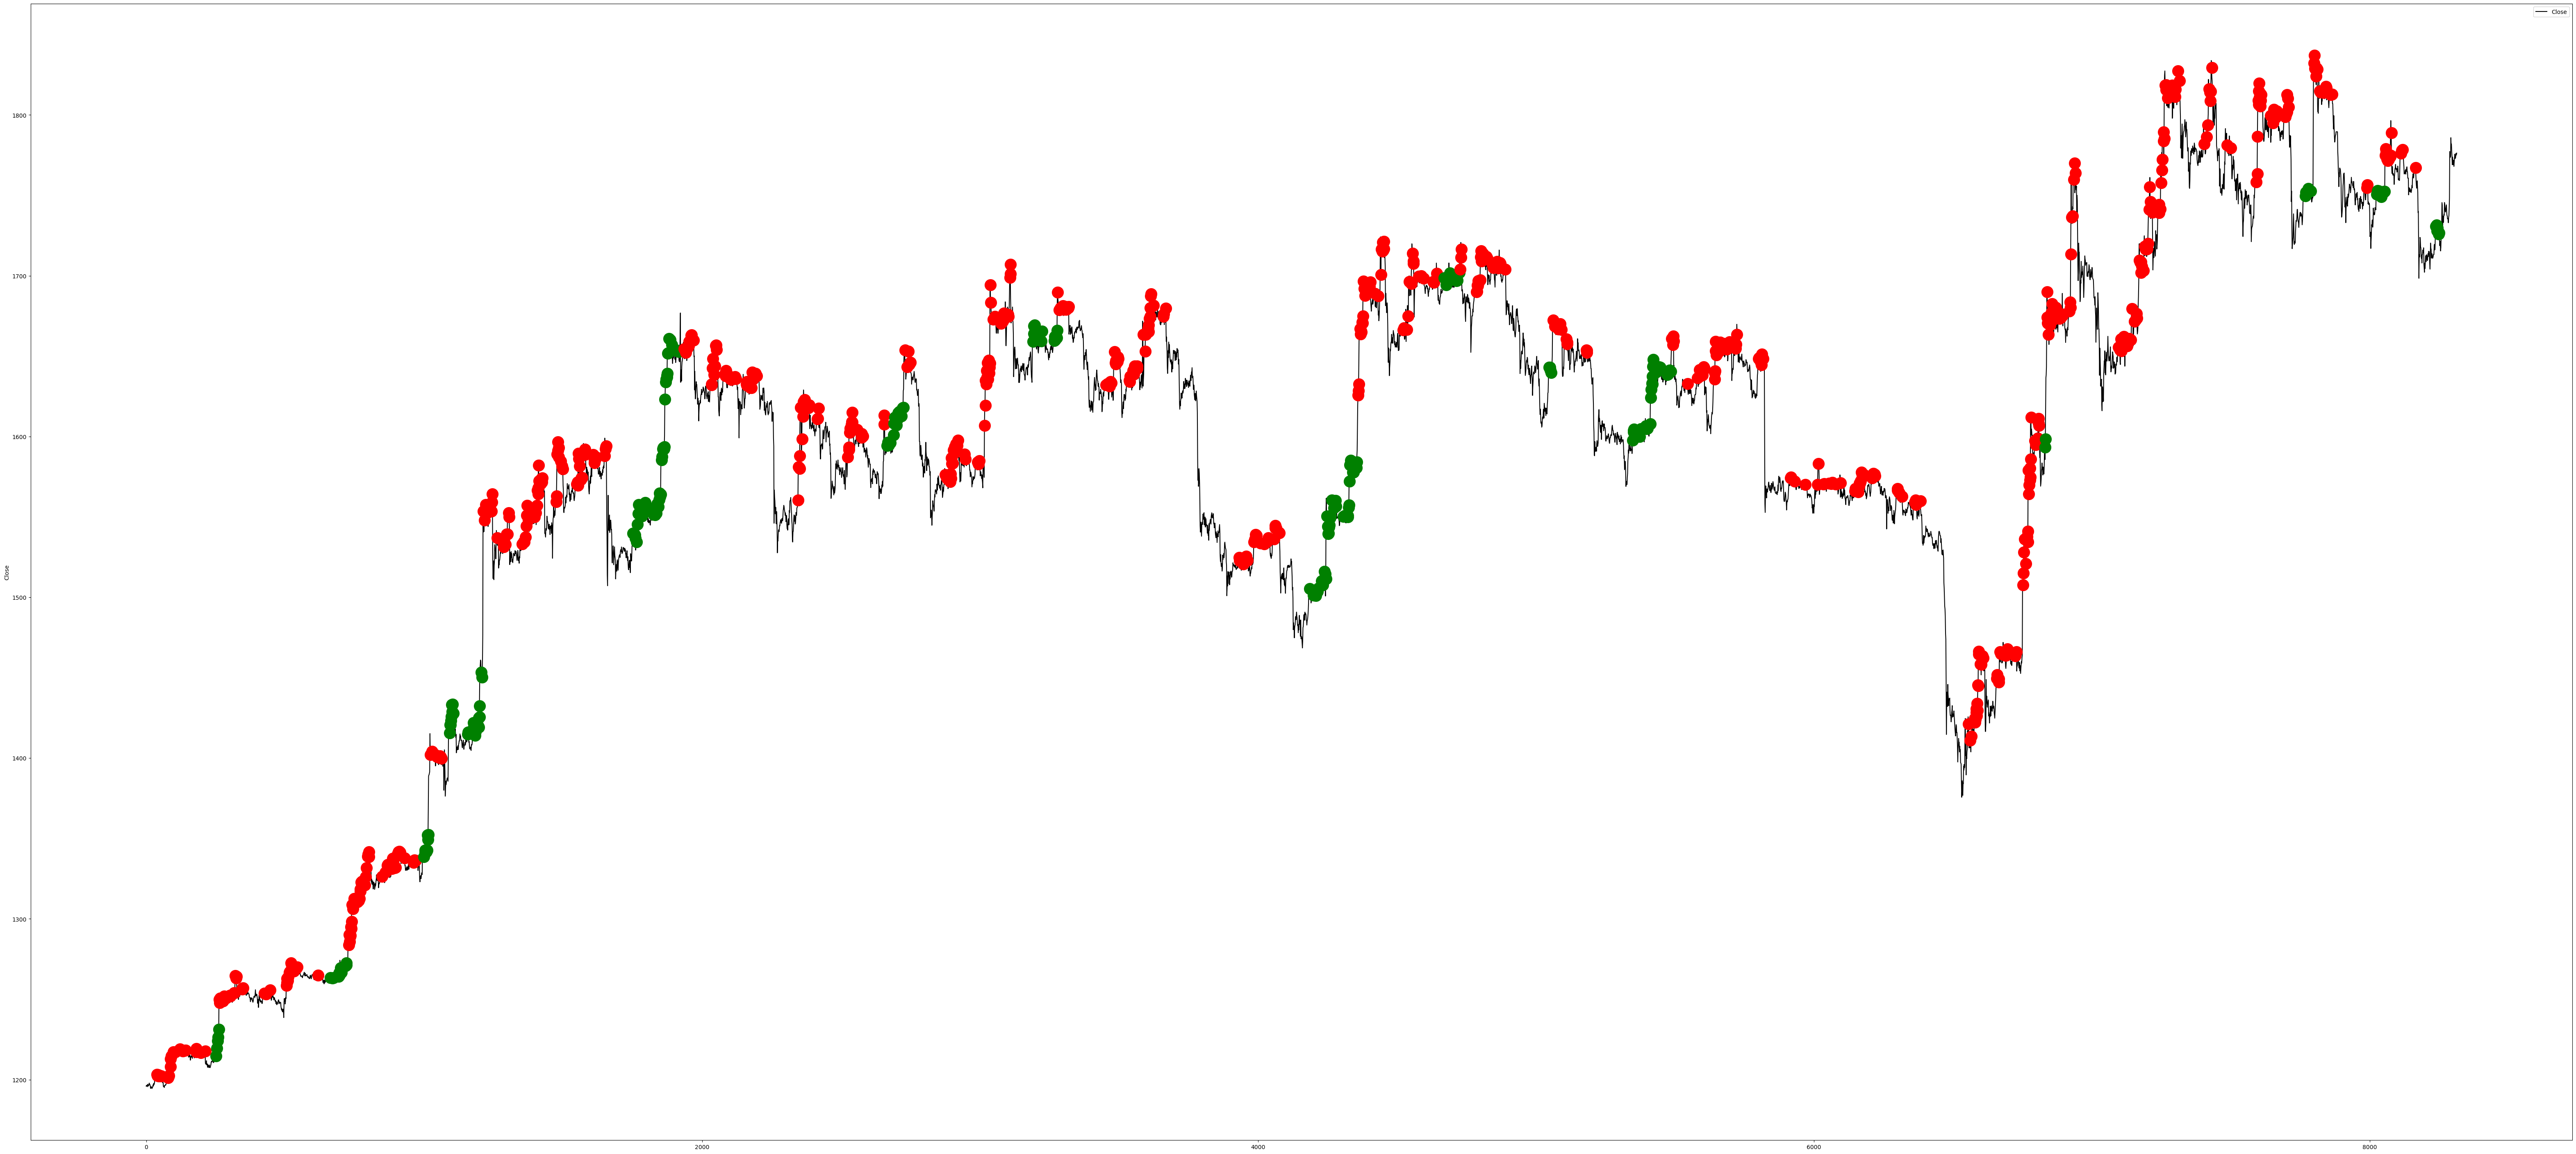

In [14]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位